In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [9]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters ///////////////////////////////////////////////////////////////////////////////////////////
random_seed = 569
learning_rate = 5e-3
num_epochs = 1000
batch_size = 64
#///////////////////////////////////////////////////////////////////////////////////////////

# Architecture
input_size = 28*28
num_classes = 2
#num_features = 784
hidden_size = 200 #500
time_step = 1
num_latent = 256
num_layers = 2

Device: cuda:0


In [3]:
# load dataset and cut it into train val part and shuffle them
data = np.loadtxt('sync_detection_data_new.txt')
label = np.loadtxt('sync_detection_label_new.txt')
N, D = np.shape(data)
label_int = np.zeros((N),dtype=int)
for k in range(N):
    label_int[k] = int(label[k])

ratio_train = 0.8 # 0.7
ind_cut = int(ratio_train * N)
ind = np.random.permutation(N)
train_data = data[ind[:ind_cut]]
train_datas = train_data[:256*20]
val_data = data[ind[ind_cut:]]

train_label = label[ind[:ind_cut]]
train_labels = train_label[:256*20]
val_label = label[ind[ind_cut:]]
print('dataset cutting success!--------------------')
print(np.shape(train_datas))

#mean = np.mean(train_datas)
#var = np.var(train_datas)
#print('preprocess----------------------------------')
#print('mean:')
#print(mean)
#print('sigma:')
#sigma = np.sqrt(var)
#print(sigma)
print('preprocess---------------------------------------------')
# preprocessing is so important
def data_in_one(inputdata):
    inputdata = (inputdata-inputdata.min())/(inputdata.max()-inputdata.min())
#    inputdata = 2.0 * inputdata - 1.0
    return inputdata

train_datas_process = data_in_one(train_data)
mean = np.mean(train_datas_process)
var = np.var(train_datas_process)
print('mean:')
print(mean)
print('sigma:')
sigma = np.sqrt(var)
print(sigma)

dataset cutting success!--------------------
(5120, 784)
preprocess---------------------------------------------
mean:
0.5472063434966757
sigma:
0.08819448838148165


In [4]:
np.shape(val_data)

(1988, 784)

In [10]:
##########################
### MODEL
##########################
print('model----------------------------------------------------------------------------------')

class VariationalAutoencoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_latent, time_step):
        super(VariationalAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.time_step = time_step
        self.encoder_lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#        self.fc = nn.Linear(hidden_size, num_classes)        
        ### ENCODER
#        self.hidden_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.z_mean = torch.nn.Linear(hidden_size, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(hidden_size, num_latent)
        
        
        ### DECODER
        self.linear_3 = torch.nn.Linear(num_latent, hidden_size*self.time_step)
        self.decoder_lstm = torch.nn.LSTM(hidden_size, input_size*time_step, num_layers, batch_first=True)

#        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features)

    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        x,_ = self.encoder_lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = x.view(-1,self.hidden_size)
        z_mean = self.z_mean(x)
#        z_mean = F.leaky_relu(z_mean, negative_slope=0.0001)
        z_log_var = self.z_log_var(x)
#        z_log_var = F.leaky_relu(z_log_var, negative_slope=0.0001)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded):
        x = self.linear_3(encoded)
#        x = F.leaky_relu(x, negative_slope=0.0001)
        x = x.view(-1,self.time_step, self.hidden_size)
        h1 = torch.zeros(self.num_layers, x.size(0), self.input_size*self.time_step).to(device) 
        c1 = torch.zeros(self.num_layers, x.size(0), self.input_size*self.time_step).to(device)
        x,_ = self.decoder_lstm(x,(h1,c1))
        x = x[:,-1,:]
        x = torch.sigmoid(x) #0~1
        decoded = x.contiguous().view(-1,self.time_step,self.input_size)
        return decoded

    def forward(self, x):
        
        z_mean, z_log_var, encoded = self.encoder(x)
        decoded = self.decoder(encoded)
#        decoded = decoded.contiguous().view(-1,784)
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = VariationalAutoencoder(input_size, hidden_size, num_latent, time_step)
model = model.to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


model----------------------------------------------------------------------------------


In [11]:
# dir_name = 'model_43.pth'
resume_flag = True
if (resume_flag==True):
    checkpoint = torch.load(dir_name)
    model.load_state_dict(checkpoint['net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
else:    
    start_epoch = 0

In [12]:
print('training ----------------------------------------------------------')
start_time = time.time()
iters = int(256*20/batch_size)
for epoch in range(start_epoch,num_epochs):
    for batch_idx in range(iters):
        features = train_datas_process[batch_idx*batch_size:(batch_idx+1)*batch_size]
#        targets = train_labels[batch_idx*batch_size:(batch_idx+1)*batch_size]
#        targets = np.transpose(targets)
        features = torch.from_numpy(features)
#        targets = torch.from_numpy(targets)
        features = features.to(device,torch.float32)
        features = features.view(-1, time_step, input_size)
        f = Variable(features)
#        targets = targets.to(device,dtype=torch.int64)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(f)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        # add condition
#        x_con = torch.cat((features, to_onehot(targets, num_classes, device)), dim=1)
        
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
#        pixelwise_bce = 0.0
        cost = kl_divergence + pixelwise_bce
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 40:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | kl_divergence: %.4f | pixelwise_bce: %.4f | Cost: %.4f'  
                   %(epoch+1, num_epochs, batch_idx, 
                     iters, kl_divergence, pixelwise_bce, cost))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

training ----------------------------------------------------------
Epoch: 114/1000 | Batch 000/080 | kl_divergence: 123.3559 | pixelwise_bce: 34204.8867 | Cost: 34328.2422
Epoch: 114/1000 | Batch 040/080 | kl_divergence: 138.6040 | pixelwise_bce: 34002.3984 | Cost: 34141.0039
Time elapsed: 0.01 min
Epoch: 115/1000 | Batch 000/080 | kl_divergence: 129.0942 | pixelwise_bce: 34168.6133 | Cost: 34297.7070
Epoch: 115/1000 | Batch 040/080 | kl_divergence: 138.2298 | pixelwise_bce: 34029.7695 | Cost: 34168.0000
Time elapsed: 0.02 min
Epoch: 116/1000 | Batch 000/080 | kl_divergence: 127.3089 | pixelwise_bce: 34182.3320 | Cost: 34309.6406
Epoch: 116/1000 | Batch 040/080 | kl_divergence: 131.1630 | pixelwise_bce: 34002.2969 | Cost: 34133.4609
Time elapsed: 0.04 min
Epoch: 117/1000 | Batch 000/080 | kl_divergence: 122.8279 | pixelwise_bce: 34211.4297 | Cost: 34334.2578
Epoch: 117/1000 | Batch 040/080 | kl_divergence: 138.2602 | pixelwise_bce: 33969.7734 | Cost: 34108.0352
Time elapsed: 0.05 min


KeyboardInterrupt: 

In [8]:
state = {'net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch }
dir_name = 'model_lstm_' + str(epoch) + '.pth'
torch.save(state, dir_name)
print (dir_name)
print('done!------------------------------------------------------------------------------')

model_lstm_112.pth
done!------------------------------------------------------------------------------


In [1]:
# infer 
Batch = 64
iters = 40 #13735/64 = 134
val_datas_process = data_in_one(val_data[:iters*Batch])
val_label = val_label[:iters*Batch]
z_runs = []
model.eval()
for batch_idx in range(iters):
    features_val = val_datas_process[batch_idx*Batch:(batch_idx+1)*Batch]
#    targets_val = val_label[batch_idx*Batch:(batch_idx+1)*Batch]
#    targets_val = np.transpose(targets_val)
    features_val = torch.from_numpy(features_val)
#    targets_val = torch.from_numpy(targets_val)
    features_val = features_val.to(device,torch.float32)
    features_val = features_val.view(-1,time_step,input_size)
    features_val = Variable(features_val)
#    targets_val = targets_val.to(device,dtype=torch.int64)

    ### infer
    z_mean, z_log_var, encoded, decoded = model(features_val)
    z_run = z_mean.to(torch.device('cpu'))
    z_run = z_run.detach().numpy()
    z_runs.append(z_run)

z_runs = np.array(z_runs)
z_runs = np.reshape(z_runs,(iters*Batch,num_latent))
np.shape(z_runs)

NameError: name 'data_in_one' is not defined

(1280, 3)


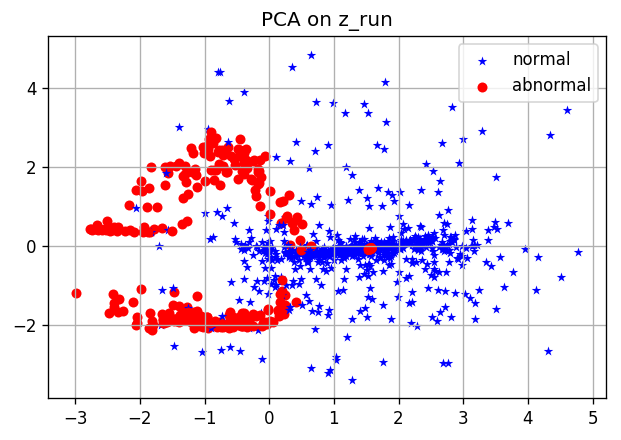

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.dpi'] = 120

# from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

#z_run = z_mean.to(torch.device('cpu'))
#z_run = z_run.detach().numpy()
PCA_model = TruncatedSVD(n_components=3).fit(z_runs)
z_run_reduced = PCA_model.transform(z_runs)
print (np.shape(z_run_reduced))
#ground_truth = targets_val.to(torch.device('cpu'))
ground_truth = val_label[:Batch*iters]
for k in range(Batch*iters):
    if ground_truth[k] ==1:
#z_mean, z_log_var, encoded, decoded = model(features, targets)
        plot1 = plt.scatter(z_run_reduced[k, 0], z_run_reduced[k, 1], c='b', marker='*', linewidths=0)
    else:
        plot2 = plt.scatter(z_run_reduced[k, 0], z_run_reduced[k, 1], c='r', marker='o', linewidths=0)        
plt.legend([plot1, plot2],('normal','abnormal'), loc='best')
plt.title('PCA on z_run')
plt.grid()
plt.show()

In [25]:
# save latenct vecotor dim = 20
np.savetxt('z_runs_136966_256.txt',z_runs)
np.savetxt('ground_truth_13696.txt',ground_truth)

In [2]:
def data_to_real(inputdata):
    inputdata = inputdata * (inputdata.max()-inputdata.min()) + inputdata.min()
#    inputdata = 2.0 * inputdata - 1.0
    return inputdata

#features1 = features.view(-1,28*28)
input_data = features_val.to(torch.device('cpu'))
input_data = input_data.detach().numpy()
input_data = data_to_real(input_data)
print(np.shape(input_data))
input_data = np.reshape(input_data,(Batch,784))
input_data = input_data[:,:783]
de = model.decoder(encoded) # replace decoded by z_mean

decoded_data = de.to(torch.device('cpu'))
#decoded_data = decoded_data.view(-1,28*28)
decoded_data = decoded_data.detach().numpy()
decoded_data = data_to_real(decoded_data)
decoded_data = np.reshape(decoded_data,(Batch,784))
decoded_data = decoded_data[:,:783]
idxx = np.random.randint(0,64)
plt.plot(input_data[idxx],'b')
plt.plot(decoded_data[idxx],'r')
plt.grid()
plt.show()

NameError: name 'features_val' is not defined